### Cora datasets

论文引用数据集，每一个点有1433维向量

最终要对每个点进行7分类任务

每个类别只有20个点有标注

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

# transform预处理
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# 获取图信息
data = dataset[0]

print()
print(f'Data: {data}')
print('=====================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree:{data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes:{data.train_mask.sum()}')
print(f'Training node label:{int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes:{data.has_isolated_nodes()}')
print(f'Has self-loops:{data.has_self_loops()}')
print(f'Is undirected:{data.is_undirected()}')



Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree:3.90
Number of training nodes:140
Training node label:0.05
Has isolated nodes:False
Has self-loops:False
Is undirected:True


2708篇论文，每个点是1433维向量；

邻接矩阵为稀疏，2维，10556个边；

val_mask和test_mask分别表示这个点需要被用到哪个集


### 可视化部分


In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE   # 降维

def visualize(h, color):
    # 数据维度太高画不出来，需要将数据降维至2维
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap='Set2')
    plt.show()

## 对比实验

### 1、传统全连接层的神经网络

In [46]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        torch.manual_seed(12345)
        self.layer1 = Linear(input_dim, hidden_dim)
        self.layer2 = Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = x.relu()
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.layer2(x)
        return x

model = MLP(input_dim=dataset.num_features,hidden_dim=16,output_dim=dataset.num_classes)
print(model)


MLP(
  (layer1): Linear(in_features=1433, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=7, bias=True)
)


In [47]:
model = MLP(input_dim=dataset.num_features,hidden_dim=16,output_dim=dataset.num_classes)
criterion = torch.nn.CrossEntropyLoss() # 交叉熵损失criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    # 模型训练
    model.train()
    # 梯度清零
    optimizer.zero_grad()
    # 模型输出
    out = model(data.x)
    # 计算有标签点的损失
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    # 反向传播，梯度更新
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x)
    prediction = out.argmax(dim=1)
    # 判断预测值是哪一个类比的概率比较大
    test_correct = prediction[data.test_mask] == data.y[data.test_mask]
    # 计算准确率
    test_accuracy = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_accuracy

In [48]:
# 训练并计算损失
from tqdm import *
for epoch in tqdm(range(1,201)):
    loss = train()
    # print(f'Loss:{loss:.4f}')
    # print(f'Epoch:{epoch:03d}, Loss:{loss:.4f}')
print(f'Loss:{loss:.4f}')

100%|██████████| 200/200 [00:00<00:00, 345.92it/s]

Loss:0.3810


In [49]:
# 准确率计算
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


### 2、GNN

将全连接层代替为GCN层

In [8]:
from torch_geometric.nn import GCNConv
import torch
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)  # 加入dropout
        x = self.conv2(x, edge_index)
        return x

model = GCN(input_dim=dataset.num_features, hidden_dim=16, output_dim=dataset.num_classes)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


未训练之前，可视化需要训练的图数据。

任务为7分类，所以输出向量维度为7维；

可视化输出时，需要将7维向量降低为2维。

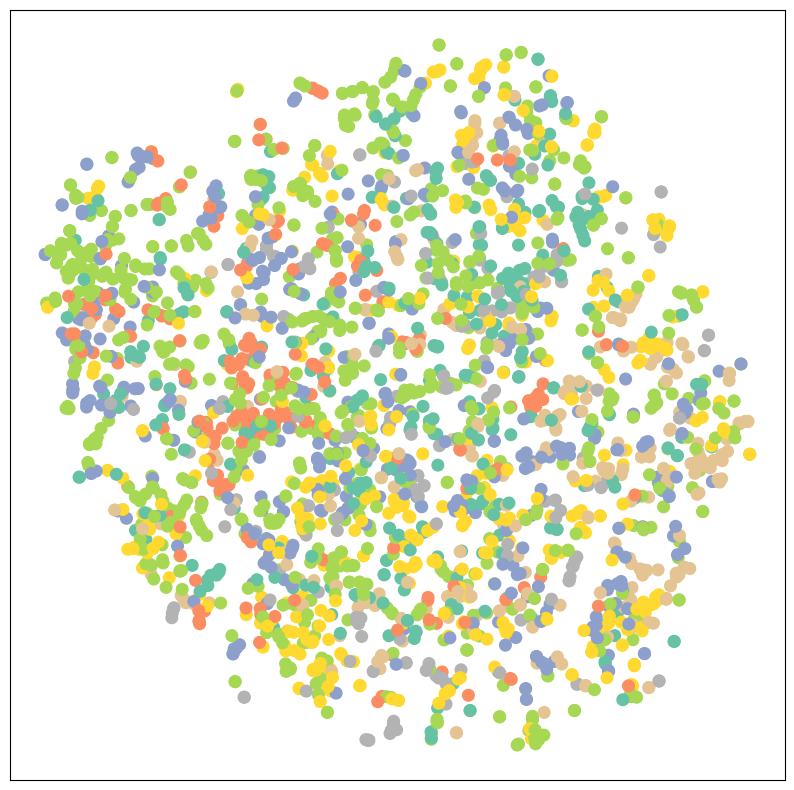

In [9]:

model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

#### 训练GCN模型
这一步分与MPL的结构完一样，需要注意的是在传入参数时，必须传入邻接矩阵。


In [10]:
model = GCN(input_dim=dataset.num_features,hidden_dim=16,output_dim=dataset.num_classes)
criterion = torch.nn.CrossEntropyLoss() # 交叉熵损失criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    # 模型训练
    model.train()
    # 梯度清零
    optimizer.zero_grad()
    # 模型输出
    "注意注意data.edge_index"
    out = model(data.x, data.edge_index)
    # 计算有标签点的损失
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    # 反向传播，梯度更新
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    "注意注意data.edge_index"
    out = model(data.x, data.edge_index)
    prediction = out.argmax(dim=1)
    # 判断预测值是哪一个类比的概率比较大
    test_correct = prediction[data.test_mask] == data.y[data.test_mask]
    # 计算准确率
    test_accuracy = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_accuracy

In [14]:
loss_list = []
accuracy_list  = []
from tqdm import *
for epoch in tqdm(range(1,201)):
    loss = train()
    loss_list.append(loss.item())
    train_Acc = test()
    accuracy_list.append(train_Acc)

print(f'Loss:{loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

100%|██████████| 200/200 [00:03<00:00, 64.82it/s]

Loss:0.2379
Test Accuracy: 0.8020


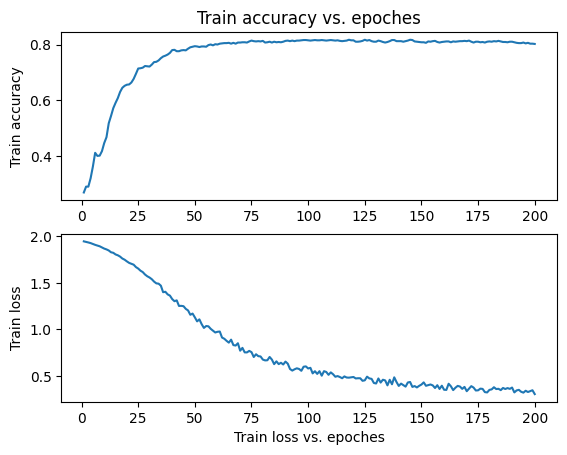

In [13]:
import matplotlib.pyplot as plt
x1 = range(1, 201)
x2 = range(1, 201)
y1 = accuracy_list
y2 = loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1)
plt.title('Train accuracy vs. epoches')
plt.ylabel('Train accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2)
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.show()

对数据进行2维可视化输出，使用不同颜色表示分类结果。

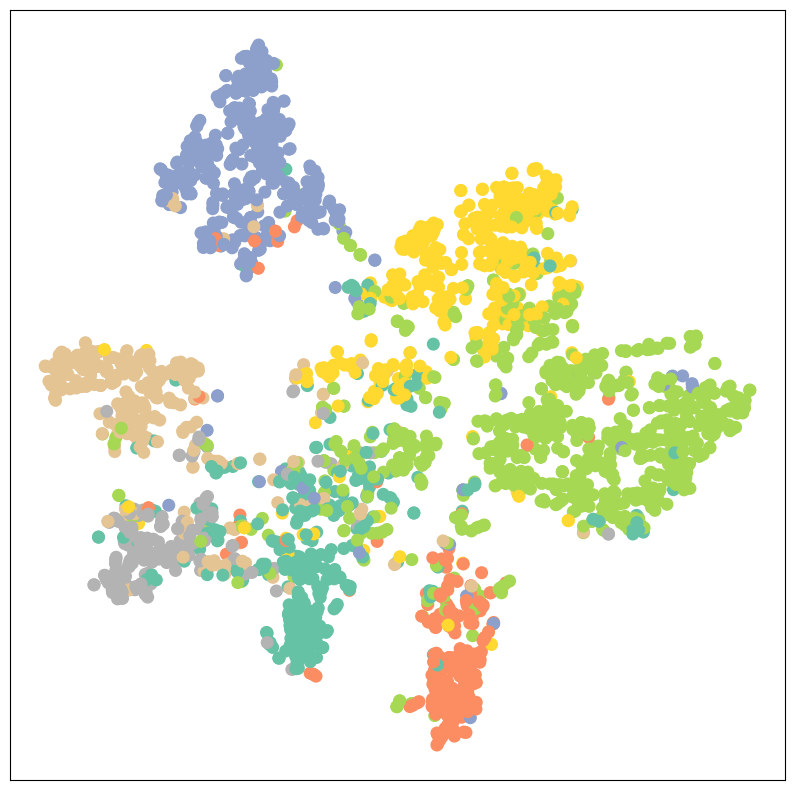

In [45]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### 3、比较

|     |  准确度  | 损失率  |
|:---:|:-----:|:----:|
| MLP | 59.0% | 0.27 |
| GCN | 80.6% | 0.23 |
